# ТМ для новостей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('../data/news.csv')
df.head()

Unnamed: 0                                              event  \
0           0  Власти Петербурга согласились передать РПЦ Иса...   
1           1  Власти Петербурга согласились передать РПЦ Иса...   
2           2  Власти Петербурга согласились передать РПЦ Иса...   
3           3  Власти Петербурга согласились передать РПЦ Иса...   
4           4  Власти Петербурга согласились передать РПЦ Иса...   

                                                text  
0   В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...  
1   Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...  
2   Аргументы и Факты (aif.ru), Москва, 14 января...  
3   Google Новости ТОП, Москва, 14 января 2017 АК...  
4   Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...

In [3]:
df.event.value_counts()

Чемпионат мира по хоккею                                                                                    102
Умер Евгений Евтушенко                                                                                      100
Митинг в москве против коррупции                                                                            100
Теракт в Барселоне                                                                                          100
Ураган в Москве                                                                                             100
Акции протеста 12 июня                                                                                      100
Саммит G20                                                                                                  100
Правительство внесло в Госдуму законопроект о курортных сборах                                              100
теракт произошел в центре Лондона                                                                       

### Препроцессинг

In [4]:
import re
from nltk.corpus import stopwords

In [5]:
from pymystem3 import Mystem
m = Mystem()

In [6]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [7]:
%%time
df.text = df.text.apply(preprocess)

CPU times: user 7.48 s, sys: 280 ms, total: 7.76 s
Wall time: 51.5 s


## Генсим

### TfidfModel

In [8]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [9]:
texts = [text.split() for text in df.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [18]:
# dictionary.token2id

In [ ]:
# поизучаем, что здесь происходит


Косинусная близость:


$$similarity=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}}$$

Вычисление сходства по косинусной мере на векторах $tf-idf$:

In [10]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [11]:
%%time
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

CPU times: user 13.6 s, sys: 8.34 s, total: 22 s
Wall time: 16.9 s


In [12]:
import seaborn as sns

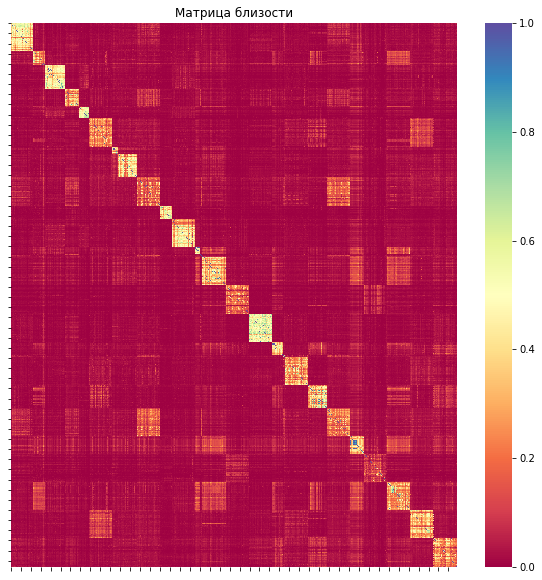

In [13]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости")
plt.show()

### Латентно-семантический анализ (LSA, LSI)


Сингулярное разложение: $M'_k = U \Sigma_k V^t_k$

* $M$ – матрица слово-документ
* $U$ – матрица слово-тема
* $k$ – число тем
* $V$ - матрица документ-тема

In [14]:
from gensim.models import lsimodel

In [15]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: user 7.28 s, sys: 1.65 s, total: 8.94 s
Wall time: 4.18 s


In [16]:
lsi.show_topics(5)

[(0,
  '0.224*"путин" + 0.166*"трамп" + 0.148*"меркель" + 0.133*"президент" + 0.127*"выборы" + 0.117*"курортный" + 0.113*"навальный" + 0.113*"акция" + 0.110*"теракт" + 0.103*"сбор"'),
 (1,
  '-0.551*"курортный" + -0.466*"сбор" + -0.234*"законопроект" + -0.212*"эксперимент" + -0.158*"инфраструктура" + -0.148*"введение" + -0.129*"вносить" + -0.119*"край" + -0.119*"крым" + -0.112*"алтайский"'),
 (2,
  '-0.393*"собор" + -0.294*"исаакиевский" + -0.227*"передача" + 0.226*"путин" + -0.224*"рпц" + 0.211*"меркель" + -0.210*"акция" + 0.161*"трамп" + -0.148*"петербург" + -0.146*"навальный"'),
 (3,
  '-0.325*"теракт" + 0.263*"собор" + -0.250*"барселона" + 0.196*"исаакиевский" + -0.173*"лондон" + 0.173*"меркель" + 0.173*"путин" + 0.152*"передача" + 0.149*"рпц" + -0.135*"евтушенко"'),
 (4,
  '0.495*"евтушенко" + 0.321*"поэт" + 0.320*"чуркин" + 0.248*"евгений" + 0.158*"умирать" + 0.157*"виталий" + -0.156*"партия" + 0.131*"оон" + -0.130*"теракт" + -0.117*"великобритания"')]

Как снижение размерности влияет на матрицу близости:

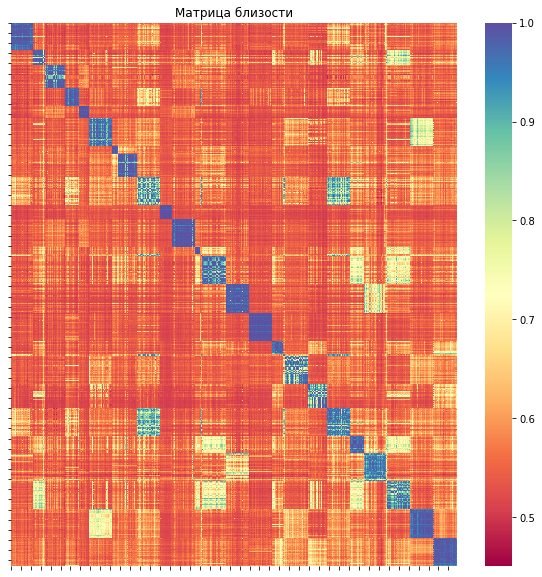

In [17]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
sims  = (sims + 1)/2.
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

### Главные компоненты

In [18]:
X = [0] * len(df)
Y = [0] * len(df)
for i in range(len(df)):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    try:
        for topic in LSI_topics:
            if topic[0] == 0:
                X[i] = topic[1]
            elif topic[0] == 1:
                Y[i] = topic[1]
    except:
        pass
vis_df = pd.DataFrame({'X': X, 'Y': Y, 'topic' : df.event})

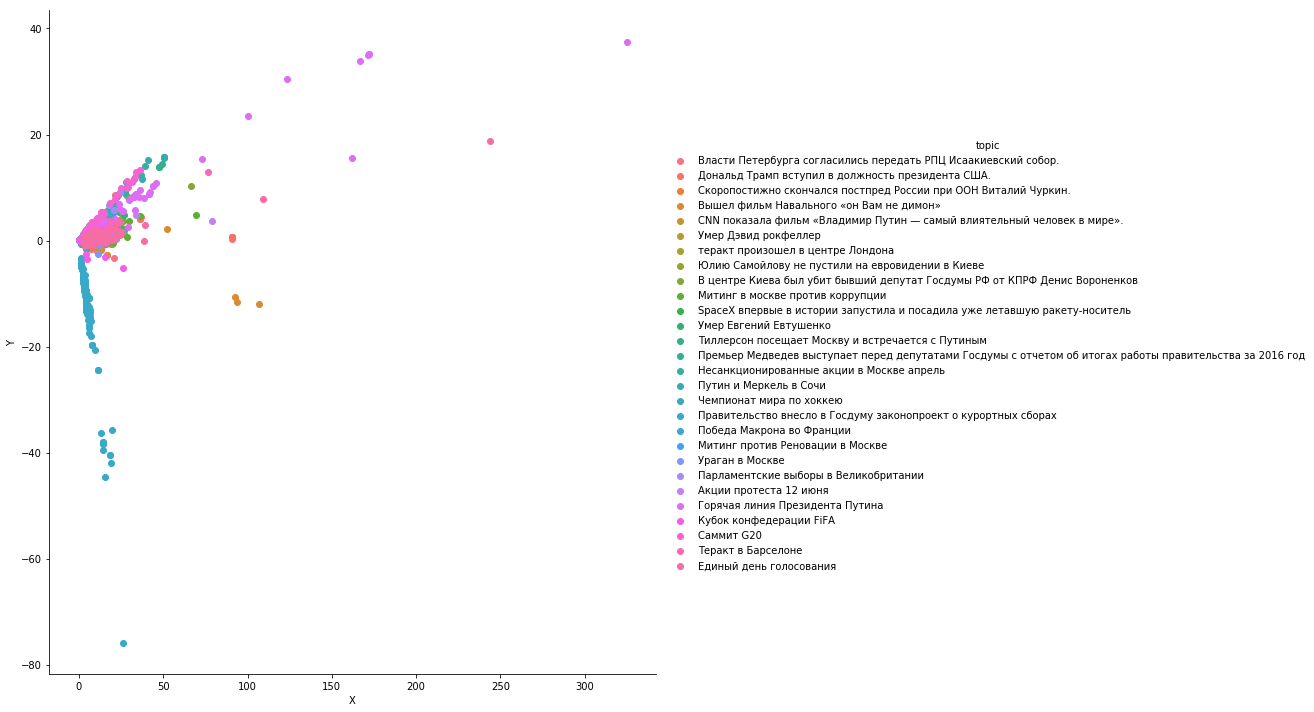

In [19]:
sns.FacetGrid(vis_df, hue="topic", size = 10).map(plt.scatter, "X", "Y").add_legend()

### Латентное размещение Дирихле [LDA]

Генеративная модель порождения документа, оценивает распределение тем по документам и слов по темам:

$p(слово|документ) = \sum_{тема} P(тема|документ) P(слово|тема)$

![](img/tm1.png)

In [20]:
from gensim.models import ldamodel

In [21]:
%%time
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=15,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)

CPU times: user 1min 11s, sys: 38.5 s, total: 1min 49s
Wall time: 37.7 s


In [22]:
lda.show_topics(15)

[(0,
  '0.014*"президент" + 0.012*"трамп" + 0.010*"выборы" + 0.009*"путин" + 0.009*"вороненков" + 0.008*"партия" + 0.007*"украина" + 0.007*"россия" + 0.006*"москва" + 0.006*"сша"'),
 (1,
  '0.015*"россия" + 0.013*"путин" + 0.011*"сборная" + 0.007*"президент" + 0.007*"матч" + 0.006*"вопрос" + 0.006*"меркель" + 0.006*"команда" + 0.006*"владимир" + 0.005*"мир"'),
 (2,
  '0.018*"евтушенко" + 0.016*"москва" + 0.013*"человек" + 0.012*"поэт" + 0.011*"евгений" + 0.011*"год" + 0.010*"ураган" + 0.007*"сообщать" + 0.006*"лондон" + 0.005*"май"'),
 (3,
  '0.015*"собор" + 0.011*"трамп" + 0.011*"россия" + 0.011*"исаакиевский" + 0.009*"передача" + 0.007*"рпц" + 0.007*"путин" + 0.007*"сша" + 0.007*"петербург" + 0.006*"президент"'),
 (4,
  '0.026*"курортный" + 0.025*"сбор" + 0.011*"год" + 0.009*"эксперимент" + 0.009*"законопроект" + 0.009*"россия" + 0.008*"инфраструктура" + 0.008*"край" + 0.007*"введение" + 0.007*"правительство"'),
 (5,
  '0.016*"медведев" + 0.012*"фонд" + 0.010*"чуркин" + 0.009*"год" +

In [23]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

In [24]:
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode()

def plot_difference(mdiff, title="", annotation=None):
    """
    Helper function for plot difference between models
    """
    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens)) 
                for (int_tokens, diff_tokens) in row
            ] 
            for row in annotation
        ]
        
    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=500, height=500, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))

In [25]:
mdiff, annotation = lda.diff(lda, distance='jaccard', num_words=50)
plot_difference(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

### Truncated SVD и TSNE

#### t-SNE
t-SNE (t-distributed Stochastic Neighbor Embedding) — техника нелинейного снижения размерности и визуализации многомерных переменных. Она разработана специально для данных высокой размерности Л. ван дер Маатеном и Д. Хинтоном. t-SNE — это итеративный алгоритм, основанный на вычислении попарных расстояний между всеми объектами (в том числе поэтому он довольно медленный).

![TSNE](TSNE.jpg)

In [28]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
vectors = TfidfVectorizer().fit_transform(df.text) # строим тф-идф матрицу документ-слово
X_reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(vectors) # оставляем n главных компонент

In [30]:
%%time
X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(X_reduced) # строим мэппинг в двухмерную плоскость с TSNE

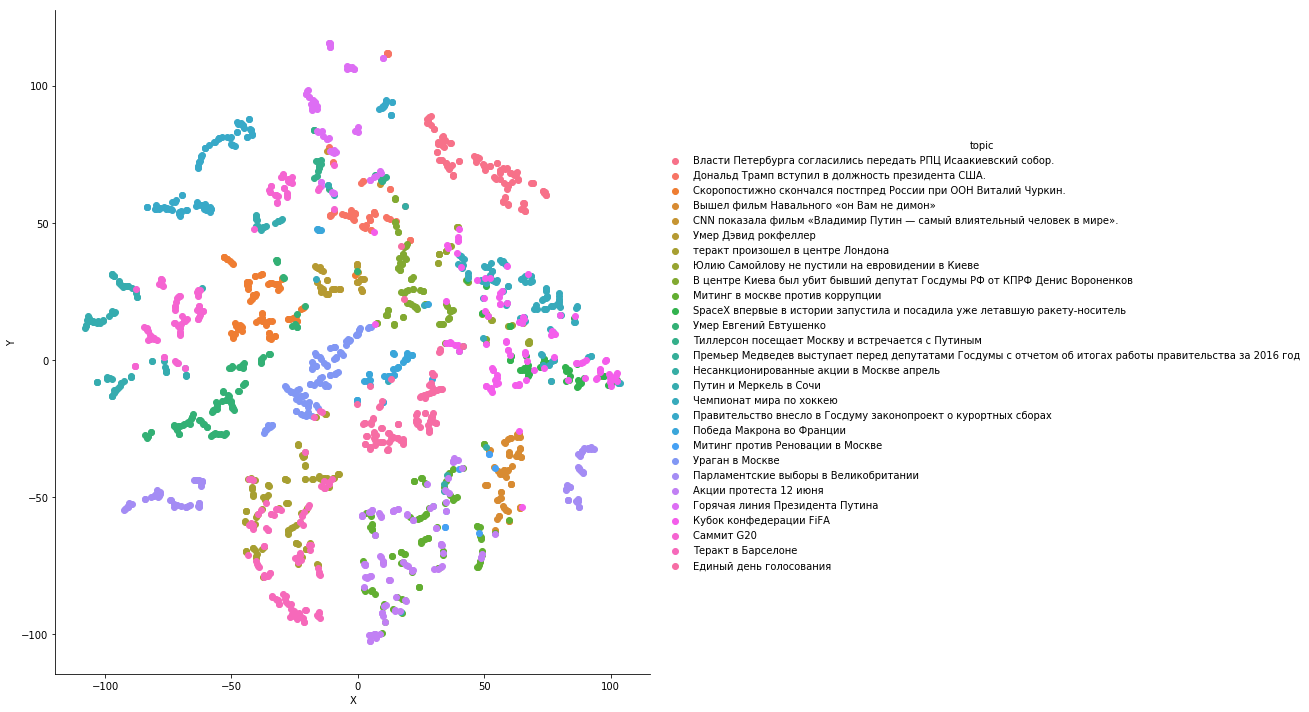

In [31]:
vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : df.event})
sns.FacetGrid(vis_df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

Advanced: [bigARTM](https://bigartm.readthedocs.io/en/stable/tutorials/python_tutorial.html)